# Imports

In [ ]:
import os
import fireducks.pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

TOTAL_MEM_KB = 15000000

# Data Preparation Functions

In [21]:
def _downsample_for_plot(df: pd.DataFrame, x: str, y: str, rule: str) -> pd.DataFrame:
    """Downsamples the DataFrame for plotting by aggregating data over time intervals.

    Preserves outliers by keeping min, mean, and max for each interval.

    Args:
        df: The input DataFrame containing the data to be downsampled.
        x: The name of the column containing timestamp data.
        y: The name of the column containing the values to be aggregated.
        rule: The offset string or object representing target conversion (e.g., '1s', '1min').

    Returns:
        A new DataFrame with downsampled data containing min, mean, and max values
        for each interval, sorted by the timestamp column.
    """
    if df.empty or not rule:
        return df

    if not pd.api.types.is_datetime64_any_dtype(df[x]):
        df[x] = pd.to_datetime(df[x], unit="s", errors='coerce')
        # Drop rows where conversion failed (NaT) to prevent errors later
        df = df.dropna(subset=[x])

    # Resample and calculate min, mean, max
    # We aggregate y by the rule on x
    grouped = df.groupby(pd.Grouper(key=x, freq=rule))[y].agg(["min", "mean", "max"])

    # 3. Drop intervals with no data
    grouped = grouped.dropna()

    # 4. Flatten the result more efficiently
    # The 'grouped' dataframe has a MultiIndex on columns now.
    # We reset the index to bring the timestamp back as a column.
    grouped = grouped.reset_index()

    # We use 'melt' to unpivot the table. This is a vectorized operation 
    # that avoids the Python 'for' loop and keeps execution in the C++ backend longer.
    # Current cols: [timestamp, (y, 'min'), (y, 'mean'), (y, 'max')]
    
    # Flatten column names for melt to work easily
    grouped.columns = [x, 'min', 'mean', 'max']
    
    # Melt converts wide format (min, mean, max columns) into long format (one column)
    downsampled = grouped.melt(id_vars=[x], value_vars=['min', 'mean', 'max'], value_name=y)
    
    # The 'variable' column from melt will contain 'min', 'mean', 'max'. 
    # If you don't need that label column, you can drop it:
    downsampled = downsampled.drop(columns=['variable'])

    # Sort by timestamp
    downsampled = downsampled.sort_values(by=x)
    
    downsampled["metric_name"] = y
    return downsampled

def _filter_metric_and_downsample(df_edge, df_cloud, metric_name):
    df_edge = df_edge[df_edge['metric_name'] == metric_name]
    df_cloud = df_cloud[df_cloud['metric_name'] == metric_name]

    df_edge = _downsample_for_plot(df_edge, "timestamp", "metric_value", "1s")
    df_cloud = _downsample_for_plot(df_cloud, "timestamp", "metric_value", "1s")
    return df_edge, df_cloud

def _align_timestamps(df_edge, df_cloud):
    # Align timestamps (Create a relative time starting at 0)
    # This assumes 'timestamp' is numerical (unix epoch). 
    df_edge['relative_time'] = df_edge['timestamp'] - df_edge['timestamp'].min()
    df_cloud['relative_time'] = df_cloud['timestamp'] - df_cloud['timestamp'].min()
    return df_edge, df_cloud

def _add_environment_identifier(df_edge, df_cloud):
    # Add an identifier column for the legend
    df_edge['Environment'] = 'Edge'
    df_cloud['Environment'] = 'Cloud'
    return df_edge, df_cloud

def prepare_data_for_chart(df_edge, df_cloud, metric_name):
    df_edge, df_cloud = _filter_metric_and_downsample(df_edge, df_cloud, metric_name)
    df_edge, df_cloud = _align_timestamps(df_edge, df_cloud)
    df_edge, df_cloud = _add_environment_identifier(df_edge, df_cloud)
    df_combined = pd.concat([df_edge, df_cloud])
    df_combined["relative_time"] = df_combined["relative_time"].dt.seconds
    return df_combined

In [22]:
def process_vmstat(df, env_label, total_mem):
  
    # Sort and Align Time
    start_time = df['timestamp'].min()
    df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds()
    
    # Calculate CPU Usage (%)
    # 'id' is idle time, so Used = 100 - Idle
    df['cpu_usage'] = 100 - df['id']
    
    # Calculate Memory Usage (%)
    # We calculate 'Active' memory (excluding Cache/Buffers)
    # Formula: (Total - Free - Buffers - Cache) / Total
    df['mem_usage'] = (total_mem - (df['free'] + df['buff'] + df['cache'])) / total_mem * 100
    
    df['Environment'] = env_label
    return df

In [23]:
def get_aggregated_data_duckdb(filepath, metric_name):
    """
    Efficiently loads and downsamples K6 CSV data using DuckDB.
    Filters by metric_name, groups by 1-second intervals, and calculates min/mean/max.
    Returns filtered and melted DataFrame ready for plotting.
    """
    query = f"""
    SELECT
        CAST(timestamp AS BIGINT) as timestamp,
        MIN(metric_value) as min_val,
        AVG(metric_value) as mean_val,
        MAX(metric_value) as max_val
    FROM read_csv('{filepath}', auto_detect=TRUE, header=TRUE)
    WHERE metric_name = '{metric_name}'
    GROUP BY timestamp
    ORDER BY timestamp
    """
    df = duckdb.query(query).to_df()
    
    # Melt matching _downsample_for_plot structure (3 values per timestamp)
    melted = df.melt(id_vars=['timestamp'], 
                     value_vars=['min_val', 'mean_val', 'max_val'], 
                     value_name='metric_value')
    # Set metric_name col for consistency
    melted['metric_name'] = metric_name 
    
    return melted

def prepare_soak_data_for_chart(df_edge, df_cloud):
    """
    Prepares pre-aggregated soak data for charting.
    Aligns timestamps and adds environment labels.
    """
    # Align timestamps
    if not df_edge.empty:
        df_edge['relative_time'] = df_edge['timestamp'] - df_edge['timestamp'].min()
    if not df_cloud.empty:
        df_cloud['relative_time'] = df_cloud['timestamp'] - df_cloud['timestamp'].min()
        
    # Add Environment
    df_edge['Environment'] = 'Edge'
    df_cloud['Environment'] = 'Cloud'
    
    df_combined = pd.concat([df_edge, df_cloud])
    # relative_time is already numeric seconds (bigint)
    return df_combined


# Smoke Tests

In [75]:
resources_k6_edge = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-edge/resources_smoke_edge.csv", skiprows=1)
resources_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/resources_smoke_cloud.csv", skiprows=1)

In [76]:
resources_k6_edge["timestamp"] = pd.to_datetime(resources_k6_edge["timestamp"])
resources_k6_cloud["timestamp"] = pd.to_datetime(resources_k6_cloud["timestamp"])

In [77]:
resources_k6_edge = resources_k6_edge.sort_values("timestamp")
resources_k6_cloud = resources_k6_cloud.sort_values("timestamp")

In [78]:
df_edge_res = process_vmstat(resources_k6_edge.copy(), 'Edge', TOTAL_MEM_KB)
df_cloud_res = process_vmstat(resources_k6_cloud.copy(), 'Cloud', TOTAL_MEM_KB)

In [79]:
# Combine for plotting
df_resources = pd.concat([df_edge_res, df_cloud_res])

In [80]:
smoke_k6_edge = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-edge/smoke_edge.csv")
smoke_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/smoke_cloud.csv")

In [81]:
smoke_k6_edge = smoke_k6_edge.sort_values("timestamp")
smoke_k6_cloud = smoke_k6_cloud.sort_values("timestamp")

In [82]:
# Align timestamps (Create a relative time starting at 0)
# This assumes 'timestamp' is numerical (unix epoch). 
smoke_k6_edge['relative_time'] = smoke_k6_edge['timestamp'] - smoke_k6_edge['timestamp'].min()
smoke_k6_cloud['relative_time'] = smoke_k6_cloud['timestamp'] - smoke_k6_cloud['timestamp'].min()

In [83]:
# Add an identifier column for the legend
smoke_k6_edge['Environment'] = 'Edge'
smoke_k6_cloud['Environment'] = 'Cloud'

In [84]:
# Combine the dataframes
df_combined = pd.concat([smoke_k6_edge, smoke_k6_cloud])

## Ack Time Analsysis

Round trip of partition leader message ack measured in ms

In [85]:
df.groupby("Environment").agg(
    avg_metric=("metric_value", "mean"),
    max_metric=("metric_value", "max"),
    min_metric=("metric_value", "min"),
    median_metric=("metric_value", "median")
)

,avg_metric,max_metric,min_metric,median_metric
Environment,,,,


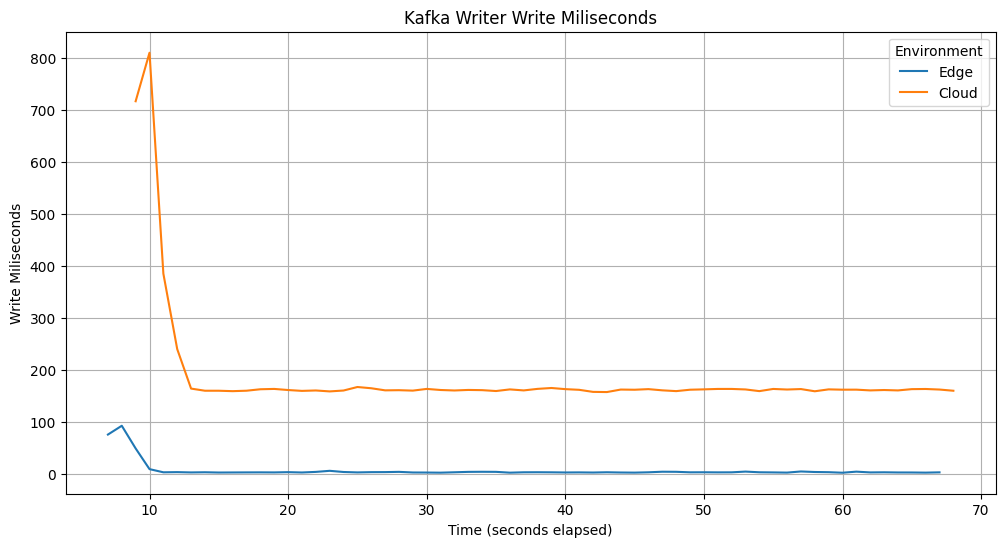

In [86]:
metric_name = 'kafka_writer_write_seconds'

df = df_combined[df_combined['metric_name'] == metric_name]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='relative_time', y='metric_value', hue='Environment', err_style=None)

plt.title('Kafka Writer Write Miliseconds')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Write Miliseconds')
plt.grid(True)
save_path = "../../data/processed/final-01/smoke/kafka_writer_write_miliseconds.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## Resource Analysis

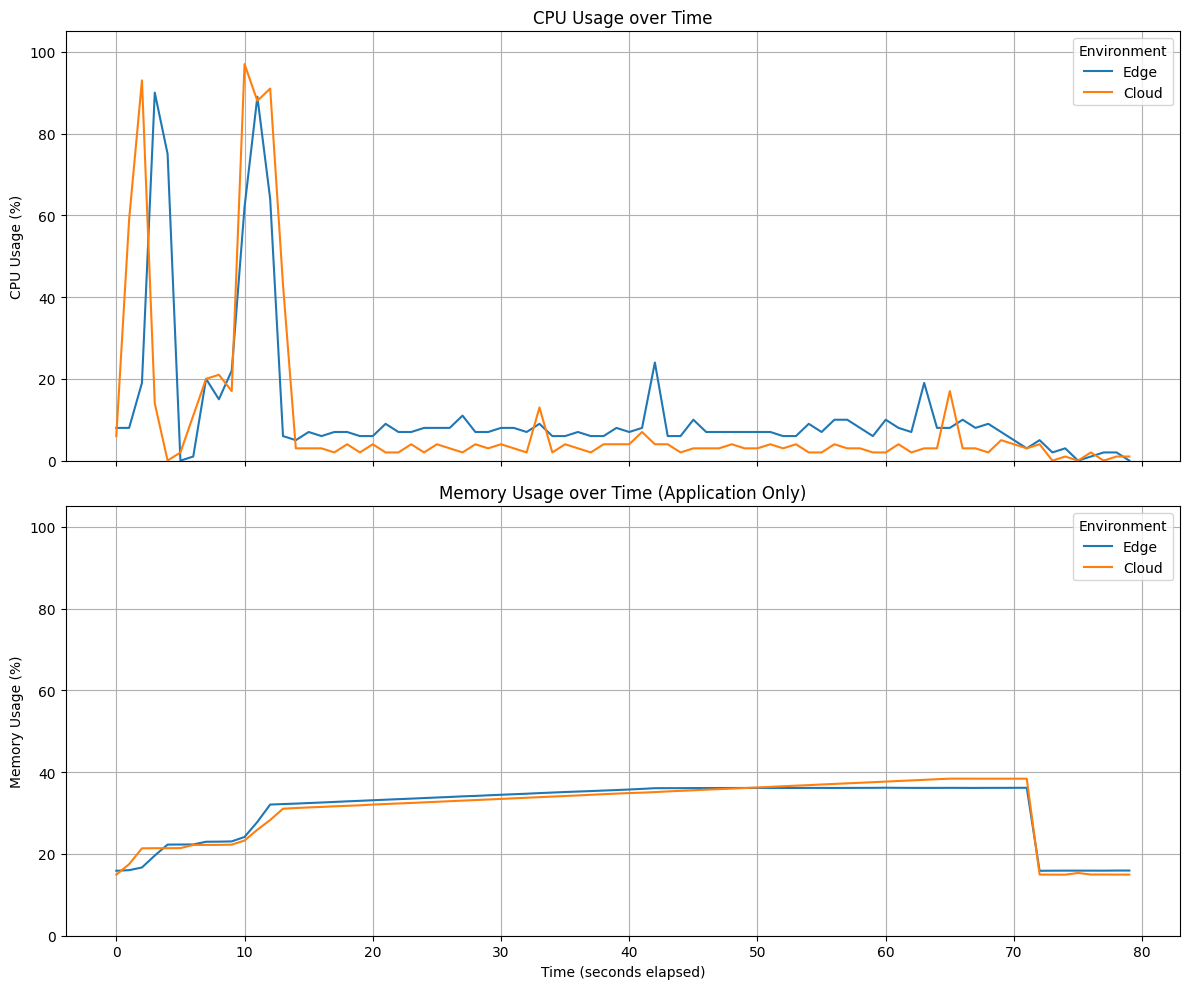

In [87]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot CPU
sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
axes[0].set_title('CPU Usage over Time')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].grid(True)
axes[0].set_ylim(0, 105) # Cap at 100% for readability

# Plot Memory
sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
axes[1].set_title('Memory Usage over Time (Application Only)')
axes[1].set_ylabel('Memory Usage (%)')
axes[1].set_xlabel('Time (seconds elapsed)')
axes[1].grid(True)
axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

plt.tight_layout()
save_path = "../../data/processed/final-01/smoke/resource_usage_producer.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## VUs analysis

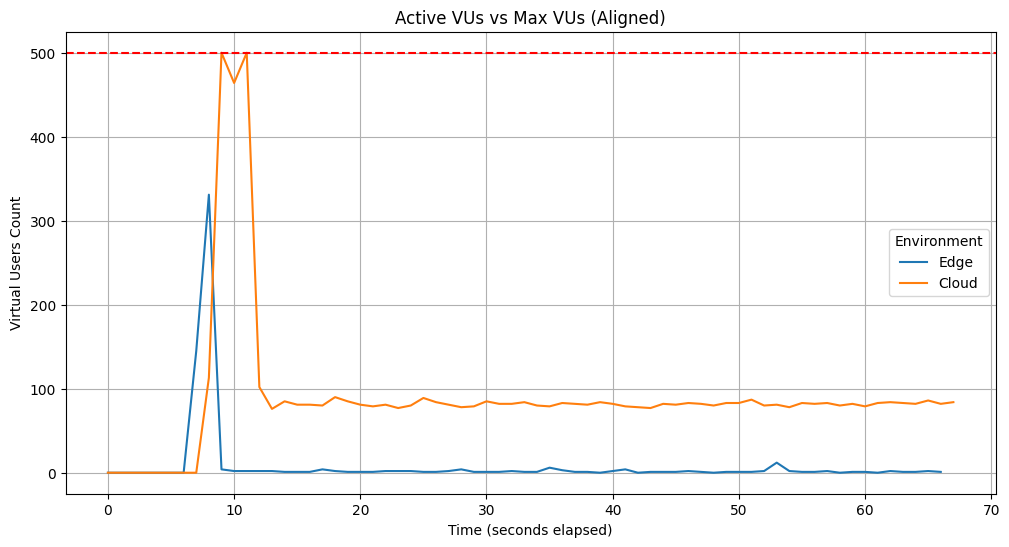

In [ ]:
metrics_of_interest = ['vus']

df = df_combined[df_combined['metric_name'].isin(metrics_of_interest)].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x='relative_time',
    y='metric_value',
    hue='Environment',   # Colors differentiate Edge vs Cloud
    markers=False,
    dashes=True,
    err_style=None
)

plt.title('Active VUs vs Max VUs (Aligned)')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Virtual Users Count')
plt.grid(True)
plt.axhline(y=500, color='red', linestyle='--', label='Target Max VUs (1200)')

save_path = "../../data/processed/final-01/smoke/vus_vus_max.png"
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

# Stress Tests

In [51]:
resources_k6_edge = pd.read_csv("../../data/raw/final-01/rerun/resources_stress_edge.csv", skiprows=1)
resources_k6_cloud = pd.read_csv("../../data/raw/final-01/rerun/resources_stress_cloud.csv", skiprows=1)

In [52]:
resources_k6_edge["timestamp"] = pd.to_datetime(resources_k6_edge["timestamp"])
resources_k6_cloud["timestamp"] = pd.to_datetime(resources_k6_cloud["timestamp"])

In [53]:
resources_k6_edge = resources_k6_edge.sort_values("timestamp")
resources_k6_cloud = resources_k6_cloud.sort_values("timestamp")

In [54]:
df_edge_res = process_vmstat(resources_k6_edge.copy(), 'Edge', TOTAL_MEM_KB)
df_cloud_res = process_vmstat(resources_k6_cloud.copy(), 'Cloud', TOTAL_MEM_KB)

In [55]:
# Combine for plotting
df_resources = pd.concat([df_edge_res, df_cloud_res])

In [56]:
stress_k6_edge = pd.read_csv("../../data/raw/final-01/rerun/stress_edge.csv")
stress_k6_cloud = pd.read_csv("../../data/raw/final-01/rerun/stress_cloud.csv")

In [57]:
stress_k6_edge = stress_k6_edge.sort_values("timestamp")
stress_k6_cloud = stress_k6_cloud.sort_values("timestamp")

## Ack Time Analysis

In [58]:
metric_name = 'kafka_writer_write_seconds'

df_writer_time = prepare_data_for_chart(stress_k6_edge, stress_k6_cloud, metric_name)

In [59]:
df_writer_time.groupby("Environment").agg(
    avg_metric=("metric_value", "mean"),
    max_metric=("metric_value", "max"),
    min_metric=("metric_value", "min"),
    median_metric=("metric_value", "median")
)

,avg_metric,max_metric,min_metric,median_metric
Environment,,,,
Cloud,1907.778674,9907.873147,0.000000,309.242301
Edge,16.838248,1042.271387,0.718802,2.975151


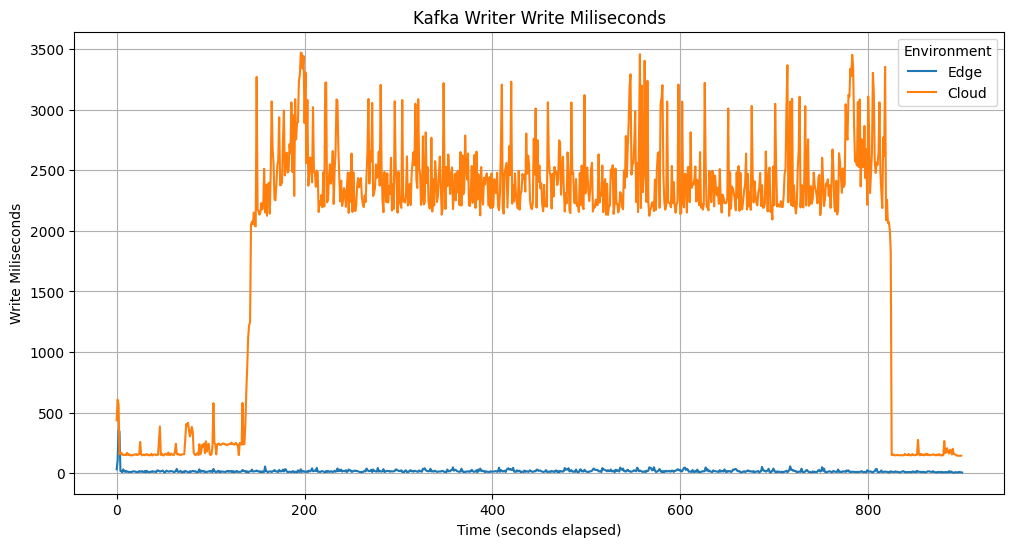

In [60]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_writer_time, x='relative_time', y='metric_value', hue='Environment', err_style=None)

plt.title('Kafka Writer Write Miliseconds')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Write Miliseconds')
plt.grid(True)
save_path = "../../data/processed/final-01/stress/kafka_writer_write_miliseconds.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## VUs Analysis

In [61]:
metric_name = 'vus'

df_vus = prepare_data_for_chart(stress_k6_edge, stress_k6_cloud, metric_name)

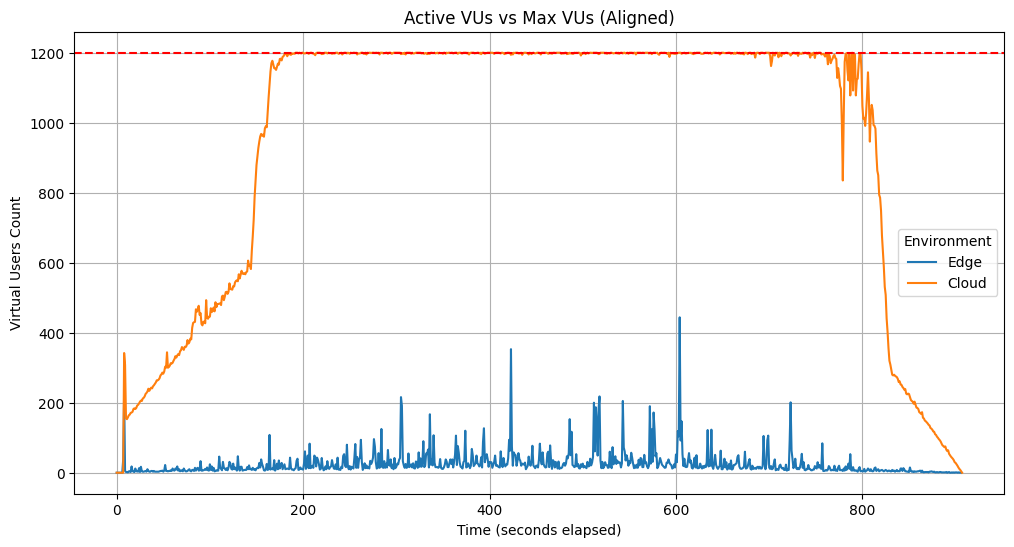

In [62]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_vus,
    x='relative_time',
    y='metric_value',
    hue='Environment',   # Colors differentiate Edge vs Cloud
    markers=False,
    dashes=True,
    err_style=None
)

plt.title('Active VUs vs Max VUs (Aligned)')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Virtual Users Count')
plt.grid(True)
plt.axhline(y=1200, color='red', linestyle='--', label='Target Max VUs (1200)')
# plt.legend(loc='upper left')

save_path = "../../data/processed/final-01/stress/vus_vus_max.png"
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## Resource Analysis

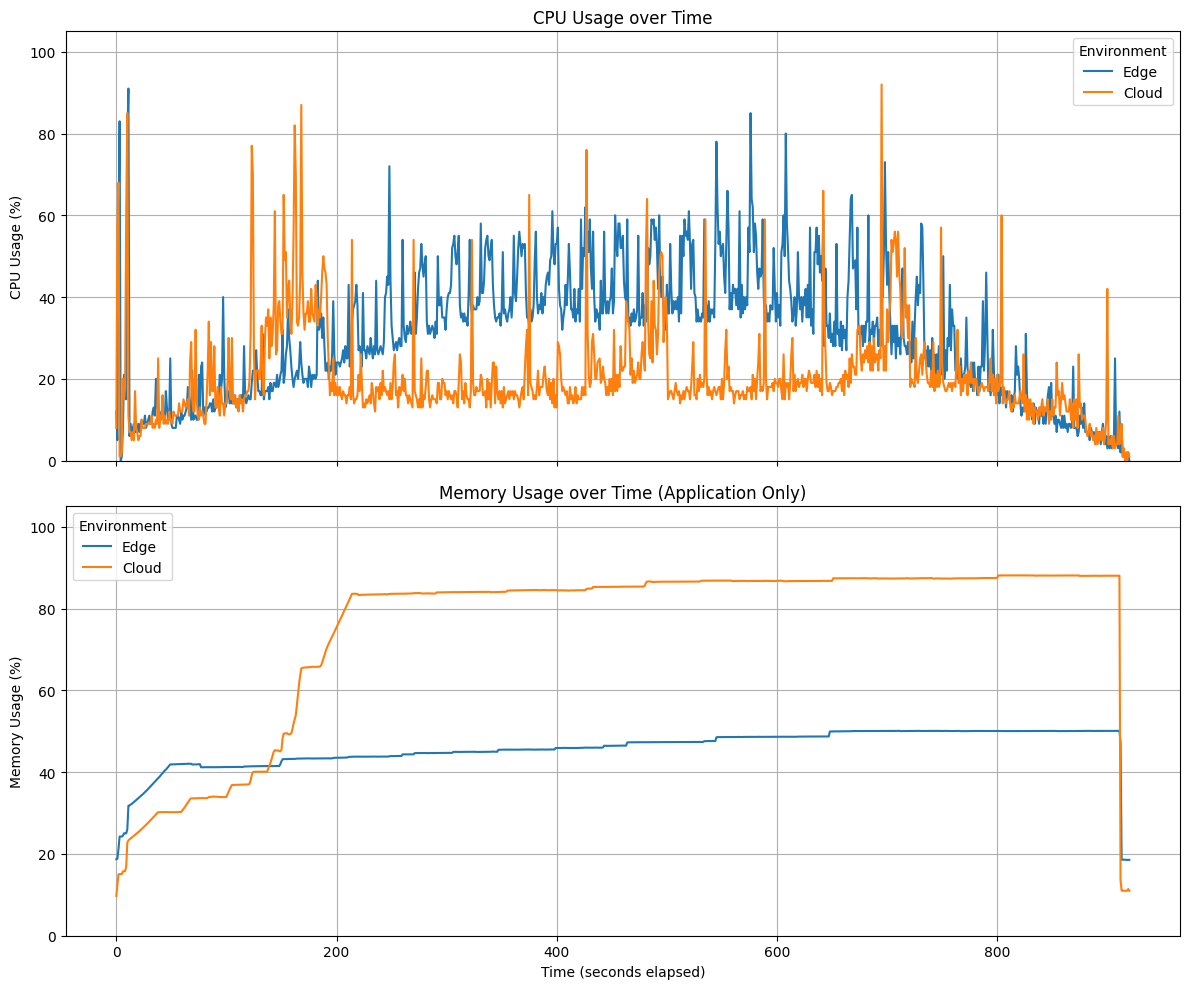

In [63]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot CPU
sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
axes[0].set_title('CPU Usage over Time')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].grid(True)
axes[0].set_ylim(0, 105) # Cap at 100% for readability

# Plot Memory
sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
axes[1].set_title('Memory Usage over Time (Application Only)')
axes[1].set_ylabel('Memory Usage (%)')
axes[1].set_xlabel('Time (seconds elapsed)')
axes[1].grid(True)
axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

plt.tight_layout()
save_path = "../../data/processed/final-01/stress/resource_usage_producer.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

# Breakpoint Tests

In [38]:
resources_k6_edge = pd.read_csv("../../data/raw/final-01/rerun/resources_breakpoint_edge.csv", skiprows=1)
resources_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/resources_breakpoint_cloud.csv", skiprows=1)

In [39]:
resources_k6_edge["timestamp"] = pd.to_datetime(resources_k6_edge["timestamp"])
resources_k6_cloud["timestamp"] = pd.to_datetime(resources_k6_cloud["timestamp"])

In [40]:
resources_k6_edge = resources_k6_edge.sort_values("timestamp")
resources_k6_cloud = resources_k6_cloud.sort_values("timestamp")

In [41]:
df_edge_res = process_vmstat(resources_k6_edge.copy(), 'Edge', TOTAL_MEM_KB)
df_cloud_res = process_vmstat(resources_k6_cloud.copy(), 'Cloud', TOTAL_MEM_KB)

In [42]:
# Combine for plotting
df_resources = pd.concat([df_edge_res, df_cloud_res])

In [54]:
breakpoint_k6_edge = pd.read_csv("../../data/raw/final-01/rerun/breakpoint_edge.csv")
breakpoint_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/breakpoint_cloud.csv")

In [44]:
breakpoint_k6_edge = breakpoint_k6_edge.sort_values("timestamp")
breakpoint_k6_cloud = breakpoint_k6_cloud.sort_values("timestamp")

## Ack Time Analsysis

Round trip of partition leader message ack measured in ms

In [49]:
metric_name = 'kafka_writer_write_seconds'

df_combined = prepare_data_for_chart(breakpoint_k6_edge, breakpoint_k6_cloud, metric_name)

In [50]:
df_combined.groupby("Environment").agg(
    avg_metric=("metric_value", "mean"),
    max_metric=("metric_value", "max"),
    min_metric=("metric_value", "min"),
    median_metric=("metric_value", "median")
)

,avg_metric,max_metric,min_metric,median_metric
Environment,,,,
Cloud,199.597184,1533.137572,0.000000,151.152223
Edge,16.749150,1048.290967,0.743806,2.891591


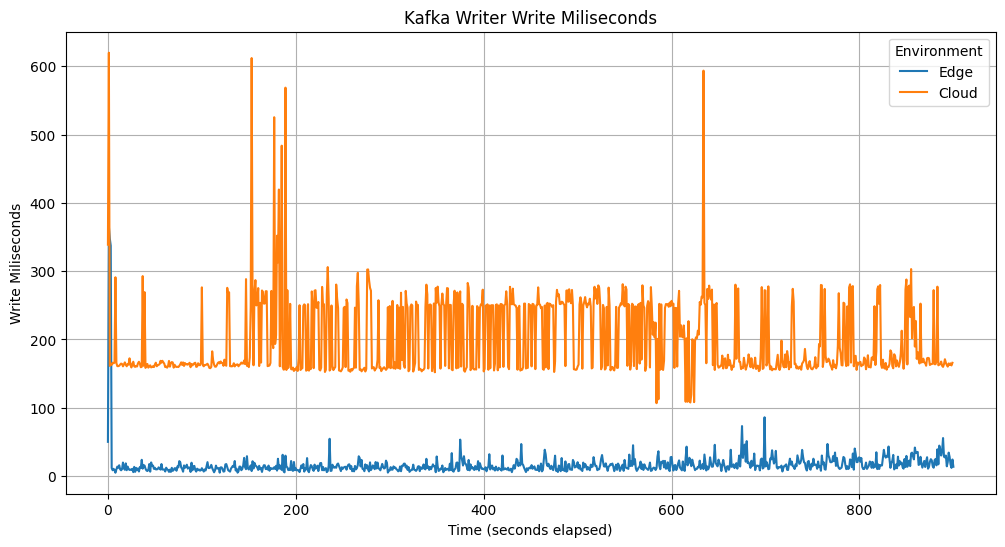

In [61]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='relative_time', y='metric_value', hue='Environment', err_style=None)

plt.title('Kafka Writer Write Miliseconds')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Write Miliseconds')
plt.grid(True)
save_path = "../../data/processed/final-01/breakpoint/kafka_writer_write_seconds.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## Resource Analysis

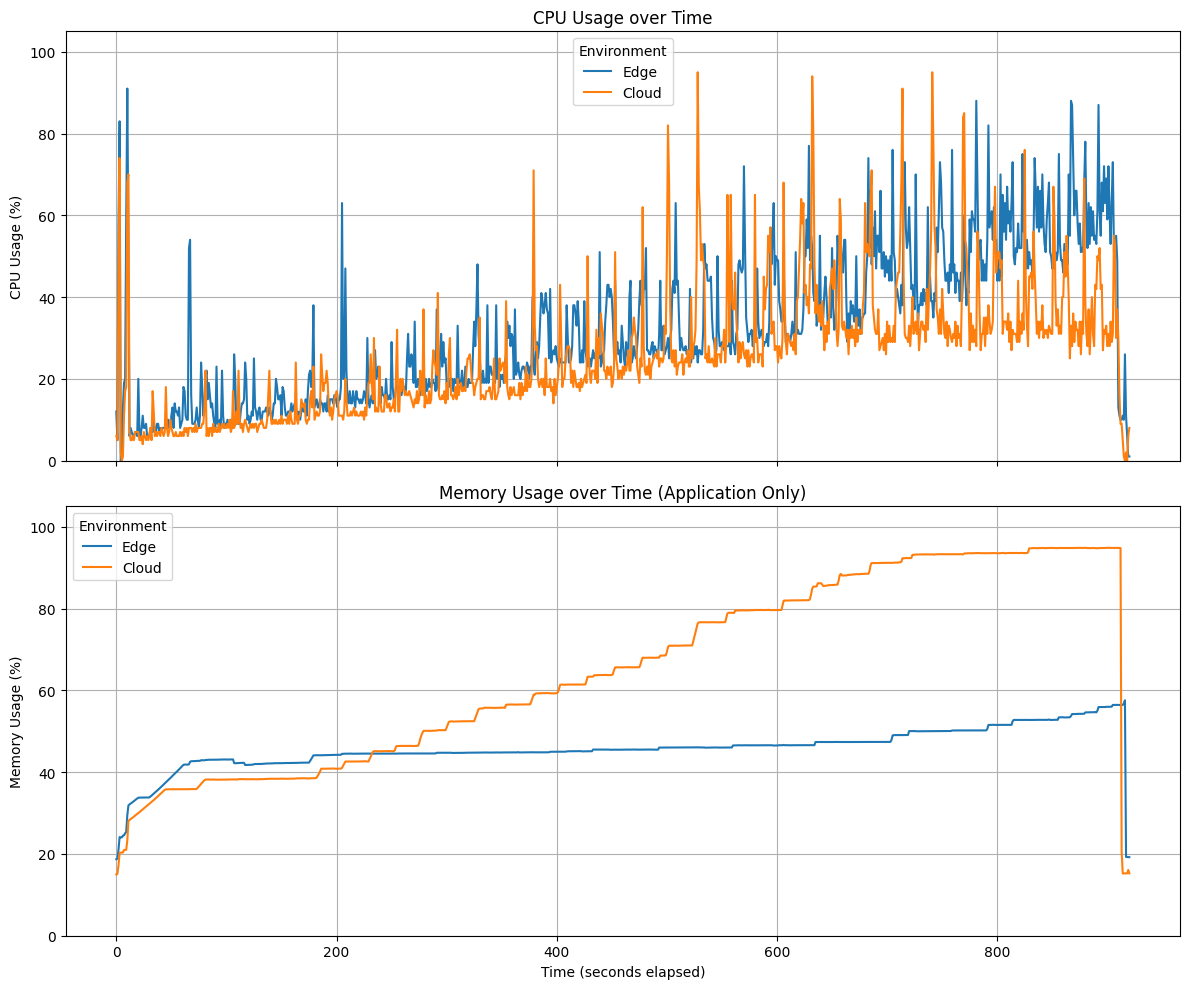

In [62]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot CPU
sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
axes[0].set_title('CPU Usage over Time')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].grid(True)
axes[0].set_ylim(0, 105) # Cap at 100% for readability

# Plot Memory
sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
axes[1].set_title('Memory Usage over Time (Application Only)')
axes[1].set_ylabel('Memory Usage (%)')
axes[1].set_xlabel('Time (seconds elapsed)')
axes[1].grid(True)
axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

plt.tight_layout()
save_path = "../../data/processed/final-01/breakpoint/resource_usage_producer.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## VUs analysis

In [67]:
metric_name = 'vus'

df_vus = prepare_data_for_chart(breakpoint_k6_edge, breakpoint_k6_cloud, metric_name)

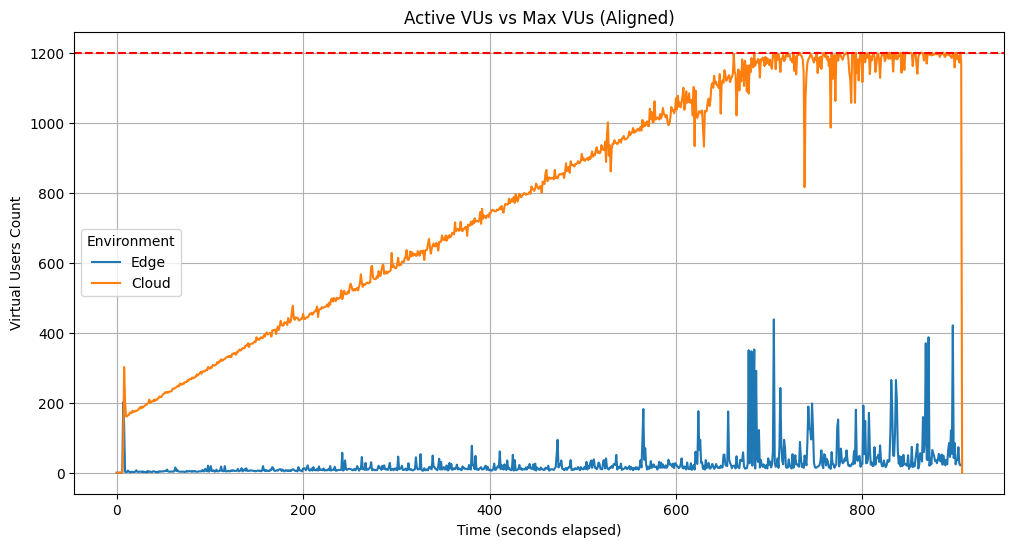

In [68]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_vus,
    x='relative_time',
    y='metric_value',
    hue='Environment',   # Colors differentiate Edge vs Cloud
    markers=False,
    dashes=True,
    err_style=None
)

plt.title('Active VUs vs Max VUs (Aligned)')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Virtual Users Count')
plt.grid(True)
plt.axhline(y=1200, color='red', linestyle='--', label='Target Max VUs (1200)')
# plt.legend(loc='upper left')

save_path = "../../data/processed/final-01/breakpoint/vus_vus_max.png"
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

# Soak Tests

In [5]:
resources_k6_edge = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-edge/resources_soak_edge.csv", skiprows=1)
resources_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/resources_soak_cloud.csv", skiprows=1)

In [6]:
resources_k6_edge["timestamp"] = pd.to_datetime(resources_k6_edge["timestamp"])
resources_k6_cloud["timestamp"] = pd.to_datetime(resources_k6_cloud["timestamp"])

In [7]:
resources_k6_edge = resources_k6_edge.sort_values("timestamp")
resources_k6_cloud = resources_k6_cloud.sort_values("timestamp")

In [8]:
df_edge_res = process_vmstat(resources_k6_edge.copy(), 'Edge', TOTAL_MEM_KB)
df_cloud_res = process_vmstat(resources_k6_cloud.copy(), 'Cloud', TOTAL_MEM_KB)

In [9]:
# Combine for plotting
df_resources = pd.concat([df_edge_res, df_cloud_res])

In [10]:
metric_name = 'kafka_writer_write_seconds'
soak_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-edge/soak_edge.csv", metric_name)
soak_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-cloud/soak_cloud.csv", metric_name)

## Ack Time Analsysis

Round trip of partition leader message ack measured in ms

In [12]:
# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(soak_k6_edge, soak_k6_cloud)

In [13]:
df_combined.groupby("Environment").agg(
    avg_metric=("metric_value", "mean"),
    max_metric=("metric_value", "max"),
    min_metric=("metric_value", "min"),
    median_metric=("metric_value", "median")
)

,avg_metric,max_metric,min_metric,median_metric
Environment,,,,
Cloud,180.678672,6039.016634,0.0,155.252432
Edge,16.878913,4659.728745,0.0,2.663183


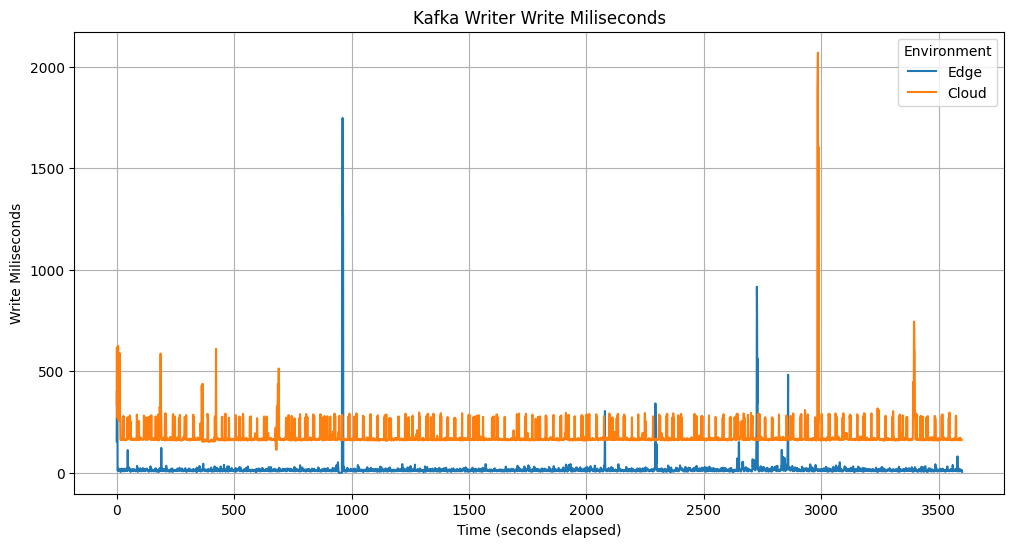

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined, x='relative_time', y='metric_value', hue='Environment', err_style=None)

plt.title('Kafka Writer Write Miliseconds')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Write Miliseconds')
plt.grid(True)
save_path = "../../data/processed/final-01/soak/kafka_writer_write_seconds.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## Resource Analysis

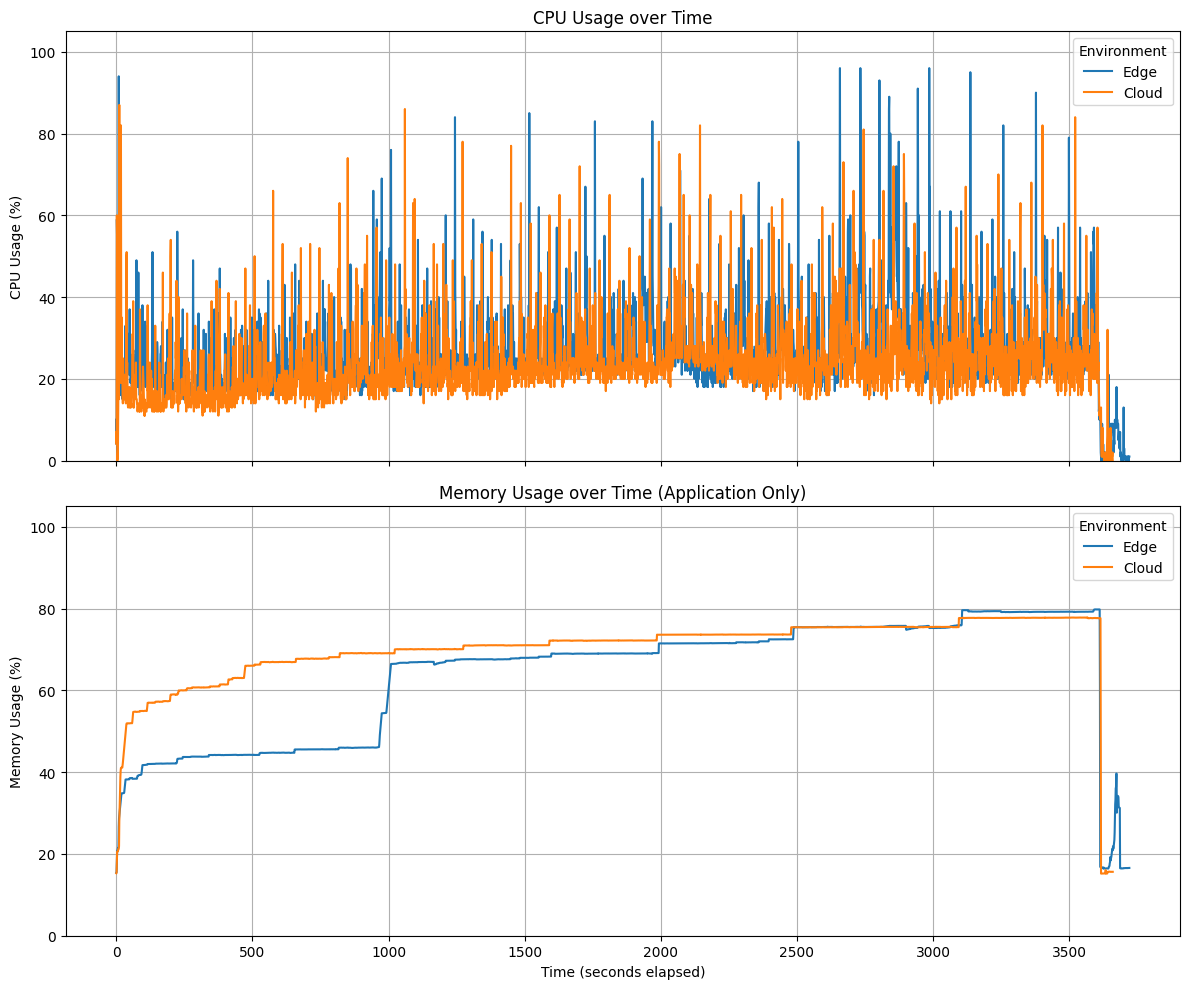

In [15]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot CPU
sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
axes[0].set_title('CPU Usage over Time')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].grid(True)
axes[0].set_ylim(0, 105) # Cap at 100% for readability

# Plot Memory
sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
axes[1].set_title('Memory Usage over Time (Application Only)')
axes[1].set_ylabel('Memory Usage (%)')
axes[1].set_xlabel('Time (seconds elapsed)')
axes[1].grid(True)
axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

plt.tight_layout()
save_path = "../../data/processed/final-01/soak/resource_usage_producer.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()

## VUs analysis

In [18]:
metric_name = 'vus'
soak_k6_edge = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-edge/soak_edge.csv", metric_name)
soak_k6_cloud = get_aggregated_data_duckdb("../../data/raw/final-01/k6_metrics/final-01-cloud/soak_cloud.csv", metric_name)

# Use specialized preparation for pre-aggregated data
df_combined = prepare_soak_data_for_chart(soak_k6_edge, soak_k6_cloud)

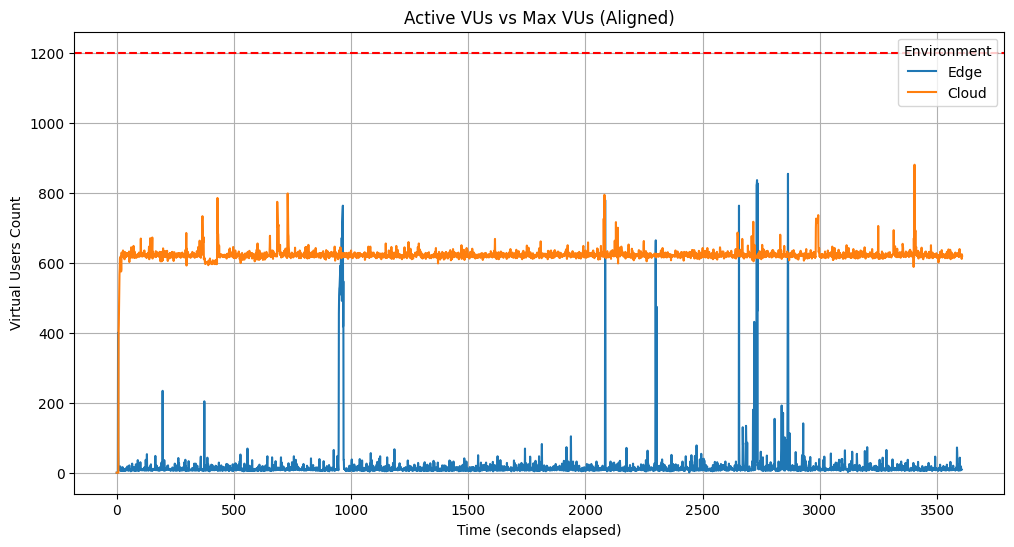

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_combined,
    x='relative_time',
    y='metric_value',
    hue='Environment',   # Colors differentiate Edge vs Cloud
    markers=False,
    dashes=True,
    err_style=None
)

plt.title('Active VUs vs Max VUs (Aligned)')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Virtual Users Count')
plt.grid(True)
plt.axhline(y=1200, color='red', linestyle='--', label='Target Max VUs (1200)')
# plt.legend(loc='upper left')

save_path = "../../data/processed/final-01/soak/vus_vus_max.png"
plt.savefig(save_path, dpi=400, bbox_inches="tight")
plt.show()